# Import 

In [ ]:
import numpy as np 
import scipy as sp
import pandas as pd
import os
import time
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import networkx as nx
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
from sklearn.metrics import silhouette_samples
from scipy.cluster.hierarchy import linkage

In [ ]:
from module.dendorgram_utils import dendrogram_clustering
from module.data_prep import prep_grn_data, prep_go_meta, prep_tf_fam_dict, prep_foodweb_data, prep_recipe_data
from module.bipartite_vectorisation import agg_list, get_bpt_dict, all_ud_bpt_vectors, bpt_list
from module.enrichment_utils import get_clustersize_range, one_test
from fvec import bipartite_cooarray, csr_row_norm, adjacency_cooarray
from module.utils import fw_typeshuff_wrapper, rn_RIshuff_wrapper, rn_RCshuff_wrapper
from module.graphpeeler import layer_realisation

In [3]:
save_things = False

# Food web:

Calculate the null model for:
1. Broadest animal categorisation in `meta_df_filtered`
2. Finest animal categorisation in `meta_fine_df_2_filtered`
3. Topological labelling from layer analysis.

In [4]:
fw_save_dir = '../../figures/fw'

In [5]:
fw_df, meta_df_filtered, meta_fine_df_filtered, meta_fine_df_2_filtered = prep_foodweb_data()

In [7]:
fw_data = {'fw': fw_df, 'meta_f': meta_df_filtered, 'meta_ff': meta_fine_df_filtered, 'meta_fff': meta_fine_df_2_filtered}

vectors = {}
for key in ['f', 'ff', 'fff']: # coarseness of food web animal labelling: more 'f's the finer...
    v = pd.read_parquet(f'../../data/foodweb/processed/{key}_vectors.parquet')
    vectors[f'{key}_vectors'] = v

In [8]:
mode = 'fff' # which level of coarseness in the food web animal labelling to use
fw_meta = fw_data[f'meta_{mode}']
fw_vectors = vectors[f'{mode}_vectors']

unique_types = fw_meta['type'].unique()
in_cols = [i + '_in' for i in unique_types]
out_cols = [i + '_out' for i in unique_types]

In [9]:
# here: broadest and finest level of food web labelling
master_meta_df = meta_df_filtered.join(meta_fine_df_2_filtered.set_index('node'), on='node', rsuffix='_finest')


In [10]:
metric = 'euclidean'
method = 'ward'

ind_to_id = fw_vectors.index.values
# Z = linkage(fw_vectors.fillna(0).iloc[:, :-2], metric=metric, method=method) 

In [11]:
# finest type to coarsest type
finest_to_coarse = master_meta_df.drop_duplicates(subset=['type', 'type_finest']).set_index('type_finest')['type'].to_dict()
# finest_to_type = master_meta_df.drop_duplicates(subset=['type', 'type_finest']).set_index('type_finest')['type'].to_dict()
finest_type_array = master_meta_df.set_index('node').loc[ind_to_id].type_finest.tolist() # finest animal type array
silscores = silhouette_samples(fw_vectors, labels=finest_type_array, metric='euclidean')

finest_type_silscore = np.mean(silscores)
print('Silhouette score for correlation with finest animal type and the vector embedding: ', finest_type_silscore)

Silhouette score for correlation with finest animal type and the vector embedding:  -0.12623349253686136


In [12]:
# sorted(list(zip(ind_to_id, silscores)), key=lambda x:x[1]) # breakdown by each node

In [13]:
coarse_meta_dict = master_meta_df.set_index('node').type.to_dict() # coarse labelling
coarse_types_unique = master_meta_df.type.unique() # unique coarse labels
ind_to_coarse = [coarse_meta_dict.get(i) for i in ind_to_id] # coarse labels for each index

coarse_to_numeric =dict(zip(coarse_types_unique, [0,0,0,0,0,1,1,1,2,2,2,2,2,3,4,5,5,5,5]))
numeric_meta_dict = dict(zip(master_meta_df.node, master_meta_df.type.apply(coarse_to_numeric.get))) # numeric labels for each animal
coarse_type_array = [numeric_meta_dict.get(i) for i in ind_to_id] # coarse labels for each index

silscores = silhouette_samples(fw_vectors, labels=coarse_type_array, metric='euclidean')
coarse_type_silscore = np.mean(silscores)
print('Silhouette score for correlation with coarsest animal type and the vector embedding: ', coarse_type_silscore)

Silhouette score for correlation with coarsest animal type and the vector embedding:  0.10167806514380784


In [14]:
master_meta_df['numeric'] = master_meta_df['type'].apply(coarse_to_numeric.get)
finest_to_coarse = master_meta_df.drop_duplicates(subset=['type_finest', 'numeric']).set_index('type_finest')['numeric'].to_dict()


In [15]:
# Graph peeler for stratifying the food web

prep_for_peeling = fw_df.copy(True)
prep_for_peeling['weight'] = 1
prep_for_peeling.columns = ['pre', 'post', 'weight']

start_ids = list(set(prep_for_peeling.pre.unique()) - set(prep_for_peeling.post.unique()))

postId = prep_for_peeling['post'].values
preId = prep_for_peeling['pre'].values
in_strengths = prep_for_peeling.groupby('post').weight.sum().to_dict()
out_strengths = prep_for_peeling.groupby('pre').weight.sum().to_dict()

weights = prep_for_peeling['weight'].values

# weight of edges as a proportion of their strength:
prep_for_peeling['in_prop_weight'] = [weights[i]/in_strengths.get(postId[i]) for i in range(len(prep_for_peeling))] 
prep_for_peeling['out_prop_weight'] = [weights[i]/out_strengths.get(preId[i]) for i in range(len(prep_for_peeling))]

# out-strength as a proportion of the total in and out strength:
out_strength_prop = {i : out_strengths.get(i, 0)/(in_strengths.get(i, 0) + out_strengths.get(i, 0)) for i in ind_to_id}

prep_for_peeling['in_div_out_prop_weight'] = [weights[i]*out_strength_prop[postId[i]]/in_strengths.get(postId[i]) for i in range(len(prep_for_peeling))]

postId = prep_for_peeling['post'].values
preId = prep_for_peeling['pre'].values
in_strengths = prep_for_peeling.groupby('post').weight.sum().to_dict()
out_strengths = prep_for_peeling.groupby('pre').weight.sum().to_dict()

weights = prep_for_peeling['weight'].values

# weight of edges as a proportion of their strength:
prep_for_peeling['in_prop_weight'] = [weights[i]/in_strengths.get(postId[i]) for i in range(len(prep_for_peeling))] 
prep_for_peeling['out_prop_weight'] = [weights[i]/out_strengths.get(preId[i]) for i in range(len(prep_for_peeling))]

# out-strength as a proportion of the total in and out strength:
out_strength_prop = {i : out_strengths.get(i, 0)/(in_strengths.get(i, 0) + out_strengths.get(i, 0)) for i in ind_to_id}

In [16]:
N=1000
d_layers = []
for i in range(N): 
    nth_r = layer_realisation(df=prep_for_peeling,
                              start_ids=start_ids,
                              correction=1, 
                              N=np.inf, 
                              seed=i, 
                              prepost='pre', 
                              prop_weight='in_prop_weight')
    id_to_layer = {}
    for key, val in nth_r.items():
        for neuron in val:
            id_to_layer[neuron] = key
    d_layers.append(pd.Series(id_to_layer, name=f'r_{i}'))

d_layer_df = pd.concat(d_layers, axis=1)
d_colname = f'm_ds_layer'
d_layer_df[d_colname] = d_layer_df.mean(axis=1).sort_values()#.round(0).astype(int) # take the mean layer across all the runs
d_layer_df.index.names=['id']
d_layer_df = d_layer_df[[d_colname]]

In [17]:
test_df = fw_vectors #all_ff_vectors.iloc[:,:-2].fillna(0)

layer_dict = d_layer_df[d_colname].round().astype(int).to_dict()
# layer_dict = ((d_layer_df['m_ds_layer'] * 2).round() / 2).astype(int).to_dict() # stratify network into layers of multiple 0.5

animal_layer_array = [str(layer_dict.get(i)) for i in ind_to_id]
# animal_type_array = fw_label_meta.set_index('node').loc[ind_to_id].type.tolist()
# numeric_type_array = [str(numeric_meta_dict.get(i)) for i in ind_to_id]

# combined_arr = [animal_layer_array[i] + '_' + str(coarse_type_array[i]) for i in range(len(ind_to_id))] # combination of labels...

test_arr = animal_layer_array # coarse_type_array

# animal_type_array = meta_finest_df.set_index('id').loc[ind_to_id].type.tolist()
silscores = silhouette_samples(test_df.loc[ind_to_id], labels=test_arr, metric='euclidean')

layer_test_silscore = np.mean(silscores)

In [18]:
# d_layer_df['round_layer'] = (d_layer_df['m_ds_layer'] * 2).round() / 2
# d_layer_df['round_layer'] = d_layer_df['m_ds_layer'].round()

In [18]:
layer_test_silscore

0.1166300174249245

In [19]:
a_AA_coo, _ = adjacency_cooarray(df=fw_df, row_col=['prey', 'predator'], id_order=ind_to_id, weight=False, directed=True)


In [ ]:

# def fw_typeshuff_wrapper(seed, meta_df, ind_to_id, a_AA_coo):
#     '''Wrapper function to recalculate the animal-type vectors 
#     We keep a_AA_coo constant (i.e. the food web structure) and shuffle the animal types.
    
#     '''
#     np.random.seed(seed)
#     meta_finest_shuff = meta_df.copy(True)
#     type_arr = meta_finest_shuff['type'].to_numpy(copy=True)
#     np.random.shuffle(type_arr)
#     meta_finest_shuff['type'] = type_arr

#     shuff_bpt_AS_coo, animal_row, type_col = bipartite_cooarray(df=meta_finest_shuff, row_col=['node', 'type'], weight=False, row_order=ind_to_id)
#     shuff_a_AS_out = (a_AA_coo @ shuff_bpt_AS_coo).tocsr() # out matrix
#     shuff_a_AS_in = (a_AA_coo.T @ shuff_bpt_AS_coo).tocsr() # in matrix

#     # out matrix normalisation:
#     shuff_a_AS_out_normalised = csr_row_norm(shuff_a_AS_out)

#     # in matrix normalisation:
#     shuff_a_AS_in_normalised = csr_row_norm(shuff_a_AS_in)

#     # put together into one dataframe:
#     # print(type(type_col[0]))
#     all_col_names = np.concatenate([
#         np.char.add(type_col, '_out'),
#         np.char.add(type_col, '_in')
#     ])
#     shuff_all_norm_vec_df = pd.DataFrame(sp.sparse.hstack([shuff_a_AS_out_normalised, shuff_a_AS_in_normalised]).toarray(), columns=all_col_names, index=animal_row)
#     return shuff_all_norm_vec_df, meta_finest_shuff

In [34]:
seeds = np.arange(1000)
# toconcat = []
coarse_null_silscores = []
layer_null_silscores = []
finest_null_silscores = []
for seed in seeds:
    shuff_all_norm_vec_df, meta_finest_shuff = fw_typeshuff_wrapper(seed, fw_meta, ind_to_id, a_AA_coo)

    # shuff_animal_type_array = meta_finest_shuff['node'].apply(lambda x: numeric_meta_dict[x]).values # this is identity preserving numeric type array
    shuff_animal_type_array = meta_finest_shuff['type'].apply(lambda x: finest_to_coarse[x]).values # this is identity consistent numeric type array
    shuff_finest_type_array = meta_finest_shuff.set_index('node').loc[ind_to_id].type.tolist() # finest animal type array

    coarse_shuff_silscores = silhouette_samples(shuff_all_norm_vec_df.loc[ind_to_id].fillna(0), labels=shuff_animal_type_array, metric='euclidean')
    finest_shuff_silscores = silhouette_samples(shuff_all_norm_vec_df.loc[ind_to_id].fillna(0), labels=shuff_finest_type_array, metric='euclidean')
    layer_shuff_silscores = silhouette_samples(shuff_all_norm_vec_df.loc[ind_to_id].fillna(0), labels=animal_layer_array, metric='euclidean') # identity preserving: layers don't change...

    coarse_null_silscores.append(np.mean(coarse_shuff_silscores))
    layer_null_silscores.append(np.mean(layer_shuff_silscores))
    finest_null_silscores.append(np.mean(finest_shuff_silscores))


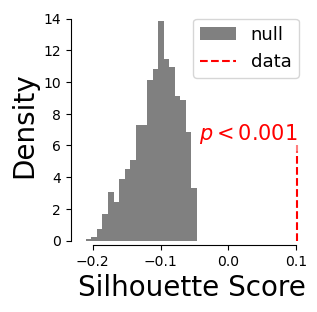

In [35]:
output = np.histogram(coarse_null_silscores, bins=20)
num_significant = sum(np.array(coarse_null_silscores) > coarse_type_silscore)
if num_significant > 0:
    pbound = num_significant/len(seeds)
else:
    pbound = 1/len(seeds)

ys = np.arange(7)
fig, ax = plt.subplots(1,1, figsize=(3,3 ))
ax.hist(coarse_null_silscores, color='grey', fill=True, density=True, bins=20, label='null')
plt.xlabel('Silhouette Score', size=20)
plt.ylabel('Density', size=20)
plt.plot([coarse_type_silscore for y in ys], ys, 'r--', label='data')
addtext = rf'$p < {pbound}$'
# addtext = f'$s={coarse_type_silscore:.2f}$\n$p < {pbound}$'

plt.text(coarse_type_silscore, ys[-1], addtext, horizontalalignment='right', \
         verticalalignment='bottom', color='red', size=15, 
         bbox=dict(boxstyle="round",
                   fc=(1, 1, 1, 0.5),
                   ec=(1,1,1,0)
                   ))

# ax.set_xticks([-0.14, -0.07, 0, 0.07, 0.14])
sns.despine(offset=3, trim=True)
plt.legend(prop={'size':13})
# save_things=False
if save_things:
    plt.savefig(f'{fw_save_dir}/f2d_coarse_null.png', dpi=300, bbox_inches='tight')
    plt.savefig(f'{fw_save_dir}/f2d_coarse_null.pdf', dpi=300, bbox_inches='tight')
plt.show()

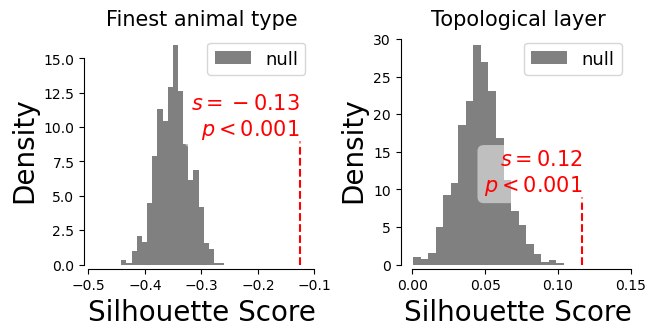

In [36]:
fig = plt.figure(figsize=(7, 3))

gs = GridSpec(1, 2, figure=fig, width_ratios=[1, 1], wspace=0.4)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])

for nulls, test_score, xranges, ax, title, label in zip([finest_null_silscores, layer_null_silscores], 
                                      [finest_type_silscore, layer_test_silscore], 
                                      [[-0.5, -0.4, -0.3, -0.2,  -0.1], [ 0, 0.05, 0.1, 0.15]], 
                                      [ax1, ax2],
                                      ['Finest animal type', 'Topological layer'], ['A', 'B']):
    # ax.text(0, 1, label, transform=ax.transAxes, fontsize=20, fontweight='bold', va='bottom',  ha='right')

    output = np.histogram(nulls, bins=20)
    num_significant = sum(np.array(nulls) > test_score)
    if num_significant > 0:
        pbound = num_significant/len(seeds)
    else:
        pbound = 1/len(seeds)

        # pbound = output[0][-1]/len(seeds)
    ys = np.arange(10)
    ax.set_title(title, size=15)
    ax.hist(nulls, color='grey', fill=True, density=True, bins=20, label='null')
    ax.set_xlabel('Silhouette Score', size=20)
    ax.set_ylabel('Density', size=20)
    ax.plot([test_score for y in ys], ys, 'r--')
    addtext = f'$s={test_score:.2f}$\n$p < {pbound}$'
    ax.text(test_score, ys[-1], addtext, horizontalalignment='right', \
            verticalalignment='bottom', color='red', size=15, 
            bbox=dict(boxstyle="round",
                    fc=(1, 1, 1, 0.5),
                    ec=(1,1,1,0)
                    ))
    ax.set_xticks(xranges)

    sns.despine(offset=3, trim=True, ax=ax)
    ax.legend(prop={'size':13})
# save_things=False
if save_things:
    plt.savefig(f'{fw_save_dir}/s_fw_silhouette_nulls.png', dpi=300, bbox_inches='tight')
    plt.savefig(f'{fw_save_dir}/s_fw_silhouette_nulls.pdf', dpi=300, bbox_inches='tight')
plt.show()

# Recipe network:

In [70]:
# rn_save_dir = '../figures/rn'
# save_things=False
if save_things:
    # grn_datadir = '../../data/grn'
    rn_save_dir = '../figures/rn'
    if not os.path.isdir(rn_save_dir):
        os.makedirs(rn_save_dir)

In [71]:
rn_df, meta_df = prep_recipe_data()
cuisine_list = meta_df.cuisine.dropna().unique()
recipe_list = rn_df.r_id.dropna().unique()

ingredient_list = list(set(rn_df.ingredient.dropna().unique()) - {''})
rn_df = rn_df[rn_df['ingredient'].isin(ingredient_list)].reset_index(drop=True)

In [72]:
cs_i_vectors = pd.read_parquet('../../data/recipe/processed/cs_i_vectors.parquet')
is_c_vectors = pd.read_parquet('../../data/recipe/processed/is_c_vectors.parquet')

## ingredient type evaluation

In [41]:
metric = 'euclidean'
method = 'ward'
ind_to_id = np.array(ingredient_list)
# ind_to_id = cs_i_vectors.columns.values

Z = linkage(cs_i_vectors.loc[ingredient_list, cuisine_list], metric=metric, method=method) ####### linkage
# Z = linkage(cs_i_vectors.loc[ingredient_list], metric=metric, method=method) ####### linkage


In [43]:
ing_categories = pd.read_csv('../../data/recipe/foodtype_categorised.csv')
ing_categories = ing_categories.iloc[:, :2]
remove = set(ing_categories.Ingredient) - set(rn_df.ingredient.unique()) 
ing_categories = ing_categories[~ing_categories.Ingredient.isin(remove)]
ing_categories.Category = ing_categories.Category.str.lower()

In [44]:
ingredient_type_dict = ing_categories.set_index('Ingredient').Category.to_dict()
sil_labels = [ingredient_type_dict.get(i) for i in ingredient_list]

In [45]:
sample_sils = silhouette_samples(cs_i_vectors.loc[ingredient_list], \
                                 metric=metric, labels=sil_labels)

In [46]:
sorted(list(zip(ingredient_list, sample_sils)), key=lambda x: x[1])

[('oak', -0.6025143814273887),
 ('fennel', -0.5509401978682217),
 ('seed', -0.5435673587217169),
 ('pine', -0.5382199649983637),
 ('almond', -0.506246090276574),
 ('milk', -0.504969233091754),
 ('beef', -0.48598639850868675),
 ('meat', -0.4843591819565178),
 ('chicken', -0.4828598357825494),
 ('cream', -0.4676527267854255),
 ('cheese', -0.45971734658073954),
 ('chicory', -0.4484613560904681),
 ('cream_cheese', -0.44090544352328337),
 ('pork', -0.43272825150109523),
 ('juniper_berry', -0.43112578424079134),
 ('pecan', -0.4288448162943918),
 ('shrimp', -0.41668172910636136),
 ('bread', -0.4134494991673379),
 ('orange_flower', -0.4072927780376148),
 ('rose', -0.4072378303181709),
 ('lamb', -0.4029580673887963),
 ('orange', -0.39930997425743386),
 ('corn', -0.39887698823991863),
 ('fir', -0.39521557866027884),
 ('veal', -0.39510720093354257),
 ('cherry', -0.39126147251113064),
 ('jasmine', -0.3907794735719811),
 ('ham', -0.3891851012465647),
 ('peanut', -0.38883880136558635),
 ('bean', -0.

In [47]:
i_sil_score = np.mean(sample_sils)

print('Ingredient type silhouette score:', i_sil_score)

Ingredient type silhouette score: -0.1989453943184878


## Cuisine type evaluation:

In [48]:
metric = 'euclidean'
method = 'ward'
ind_to_id = np.array(cuisine_list)
Z = linkage(is_c_vectors.loc[ind_to_id, ingredient_list], metric=metric, method=method) ####### linkage


In [49]:
ind_to_cuisine_dict = {'Vietnamese': 'SE_Asia',
 'Indian': 'S_Asia_Middle_East',
 'French': 'N_Europe',
 'Jewish': 'N_Europe',
 'Spanish_Portuguese': 'S_Europe',
 'Central_SouthAmerican': 'South_America',
 'Cajun_Creole': 'North_America',
 'Thai': 'SE_Asia',
 'Scandinavian': 'N_Europe',
 'Greek': 'S_Europe',
 'American': 'North_America',
 'African': 'Africa',
 'MiddleEastern': 'S_Asia_Middle_East',
 'EasternEuropean_Russian': 'N_Europe',
 'Italian': 'S_Europe',
 'Irish': 'N_Europe',
 'Mexican': 'North_America',
 'Chinese': 'E_Asia',
 'German': 'N_Europe',
 'Mediterranean': 'S_Europe',
 'Japanese': 'E_Asia',
 'Moroccan': 'Africa',
 'Southern_SoulFood': 'North_America',
 'English_Scottish': 'N_Europe',
 'Asian': 'E_Asia',
 'Southwestern': 'North_America'}


In [50]:
ind_to_cuisinetype = [ind_to_cuisine_dict.get(i) for i in ind_to_id]
sil_labels = ind_to_cuisinetype

In [51]:
sample_sils = silhouette_samples(is_c_vectors.loc[ind_to_id, ingredient_list], \
                                 metric=metric, labels=sil_labels)

In [52]:
sorted(list(zip(ind_to_id, sample_sils)), key=lambda x:x[1])

[('Mexican', -0.6524540769332292),
 ('MiddleEastern', -0.5258376861966056),
 ('Southwestern', -0.43890841329755265),
 ('American', -0.2238299487281408),
 ('Indian', -0.15684617008651555),
 ('Southern_SoulFood', -0.12409381046265397),
 ('Cajun_Creole', -0.044960577952607376),
 ('Central_SouthAmerican', 0.0),
 ('Jewish', 0.1019928736185197),
 ('French', 0.1403102633016306),
 ('German', 0.1893443656857522),
 ('Spanish_Portuguese', 0.20949022629637168),
 ('Irish', 0.24167164320012063),
 ('Scandinavian', 0.2655248729559757),
 ('African', 0.27926940586833154),
 ('EasternEuropean_Russian', 0.290590058096026),
 ('Asian', 0.29099028603459526),
 ('English_Scottish', 0.30571955635198345),
 ('Italian', 0.37716962145179567),
 ('Greek', 0.37817912996912106),
 ('Mediterranean', 0.39888971252654587),
 ('Moroccan', 0.40481059204967307),
 ('Thai', 0.4098770567400829),
 ('Japanese', 0.41310575147469686),
 ('Vietnamese', 0.44821801448318305),
 ('Chinese', 0.4636631602946873)]

In [53]:
c_sil_score = np.mean(sample_sils)
print('Cuisine type silhouette score:', c_sil_score)

Cuisine type silhouette score: 0.13238022718237644


## Null models:

In [54]:
# initialise the necessary matrices for the recipe-ingredient and recipe-cuisine networks

a_RC_coo, recipe_row, cuisine_col = bipartite_cooarray( \
    df=meta_df.sort_values(['r_id', 'cuisine']), \
    row_col=['r_id', 'cuisine'], \
    weight=False, \
    row_order=list(recipe_list), \
    col_order=list(cuisine_list))

a_RI_coo, recipe_row, ingredient_col = bipartite_cooarray( \
        df=rn_df.sort_values(['r_id', 'ingredient']), \
        row_col=['r_id', 'ingredient'], \
        weight=False, \
        row_order=list(recipe_list), \
        col_order=list(ingredient_list))


In [ ]:
# def rn_RCshuff_wrapper(seed, a_RI_coo, meta_df, recipe_list, cuisine_col, ingredient_col):
#     '''Wrapper function to recalculate the ingredient-space cuisine vectors 
#     and the cuisine space ingredient vectors, from keeping Recipe-Ingredient adjacency matrix
#     constant. 

#     Shuffles the labels in the recipe-cuisine df meta_df.

#     '''
#     np.random.seed(seed)
#     meta_df_bpt_shuff = meta_df.copy(True)
#     type_arr = meta_df_bpt_shuff['cuisine'].to_numpy(copy=True)
#     np.random.shuffle(type_arr)
#     meta_df_bpt_shuff['cuisine'] = type_arr

#     a_RC_coo, recipe_row, _ = bipartite_cooarray( \
#         df=meta_df_bpt_shuff.sort_values(['r_id', 'cuisine']), \
#         row_col=['r_id', 'cuisine'], \
#         weight=False, \
#         row_order=list(recipe_list), \
#         col_order=list(cuisine_col))

#     a_CI_csr = (a_RC_coo.T @ a_RI_coo).tocsr() # csr array

#     # normalisation:
#     a_CI_csr_normalised = csr_row_norm(a_CI_csr)
#     norm_is_c_vec_df = pd.DataFrame(a_CI_csr_normalised.toarray(), columns=ingredient_col, index=cuisine_col)

#     a_IC_csr = a_CI_csr.T
#     # standarisation - correct for the number of recipes in each cuisine:
#     r_sums = np.array(a_RC_coo.tocsr().sum(axis=0)).flatten()  
#     r_sums[r_sums == 0] = 1 # divide by 1 instead of zero
#     inv_r_sums = sp.sparse.diags(1 / r_sums)
#     standardised_a_IC_csr = a_IC_csr @ inv_r_sums

#     # normalisation:
#     a_IC_csr_s_normalised = csr_row_norm(standardised_a_IC_csr)
#     cnorm_cs_i_bpt_df = pd.DataFrame(a_IC_csr_s_normalised.toarray(), columns= cuisine_col, index=ingredient_col)
#     return norm_is_c_vec_df, cnorm_cs_i_bpt_df


# def rn_RIshuff_wrapper(seed, a_RC_coo, rn_df, recipe_list, cuisine_col, ingredient_list):
#     '''Wrapper function to recalculate the ingredient-space cuisine vectors 
#     and the cuisine space ingredient vectors, from keeping recipe-cuisine adjacency matrix
#     constant. 

#     Shuffles the labels in the recipe-ingredient dataframe rn_df 

#     '''
#     np.random.seed(seed)
#     rn_df_shuff = rn_df.copy(True)
#     type_arr = rn_df_shuff['r_id'].to_numpy(copy=True)
#     np.random.shuffle(type_arr)
#     rn_df_shuff['r_id'] = type_arr
#     rn_df_shuff.drop_duplicates(inplace=True)

#     a_RI_coo, recipe_row, ingredient_col = bipartite_cooarray( \
#         df=rn_df_shuff.sort_values(['r_id', 'ingredient']), \
#         row_col=['r_id', 'ingredient'], \
#         weight=False, \
#         row_order=list(recipe_list), \
#         col_order=list(ingredient_list))
#     # t1 = time.perf_counter()

#     a_CI_csr = (a_RC_coo.T @ a_RI_coo).tocsr() # csr array

#     # normalisation:
#     a_CI_csr_normalised = csr_row_norm(a_CI_csr)
#     norm_is_c_vec_df = pd.DataFrame(a_CI_csr_normalised.toarray(), columns=ingredient_col, index=cuisine_col)

#     a_IC_csr = a_CI_csr.T
#     # standarisation - correct for the number of recipes in each cuisine:
#     r_sums = np.array(a_RC_coo.tocsr().sum(axis=0)).flatten()  
#     r_sums[r_sums == 0] = 1 # divide by 1 instead of zero
#     inv_r_sums = sp.sparse.diags(1 / r_sums)
#     standardised_a_IC_csr = a_IC_csr @ inv_r_sums

#     # normalisation:
#     a_IC_csr_s_normalised = csr_row_norm(standardised_a_IC_csr)
#     cnorm_cs_i_bpt_df = pd.DataFrame(a_IC_csr_s_normalised.toarray(), columns= cuisine_col, index=ingredient_col)
#     # t2 = time.perf_counter()
#     return norm_is_c_vec_df, cnorm_cs_i_bpt_df



In [63]:
# randomised cuisine nulls:
seeds= np.arange(1000)
continent_labels = [ind_to_cuisine_dict.get(i) for i in cuisine_list]
ingredient_labels = [ingredient_type_dict.get(i) for i in ingredient_list]

RCshuff_is_c_sil_means = []
RCshuff_cs_i_sil_means = []

for seed in seeds:
    output = rn_RCshuff_wrapper(
        seed=seed, \
        a_RI_coo=a_RI_coo, \
        meta_df=meta_df, \
        recipe_list=recipe_list, \
        cuisine_col=cuisine_col, \
        ingredient_col=ingredient_col)
    
    norm_is_c_vec_df_RCshuff, cnorm_cs_i_bpt_df_RCshuff = output

    # both identity preserving nulls:
    RC_shuff_is_c_null_sils = silhouette_samples(norm_is_c_vec_df_RCshuff.loc[cuisine_list, ingredient_list], \
                                    metric=metric, labels=continent_labels)
    RC_shuff_cs_i_null_sils = silhouette_samples(cnorm_cs_i_bpt_df_RCshuff.loc[ingredient_list], \
                                 metric=metric, labels=ingredient_labels)

    RCshuff_is_c_sil_means.append(np.mean(RC_shuff_is_c_null_sils))
    RCshuff_cs_i_sil_means.append(np.mean(RC_shuff_cs_i_null_sils))

# 38s

In [57]:
# randomised recipe nulls:
seeds = np.arange(1000)
continent_labels = [ind_to_cuisine_dict.get(i) for i in cuisine_list]
ingredient_labels = [ingredient_type_dict.get(i) for i in ingredient_list]

RIshuff_is_c_sil_means = []
RIshuff_cs_i_sil_means = []

for seed in seeds:    
    output = rn_RIshuff_wrapper(
        seed=seed, \
        a_RC_coo=a_RC_coo, \
        rn_df=rn_df, \
        recipe_list=recipe_list, \
        cuisine_col=cuisine_col, \
        ingredient_list=ingredient_list)
    norm_is_c_vec_df_RIshuff, cnorm_cs_i_bpt_df_RIshuff = output # an instance of a shuffled vectors

    # calculate the silhouette scores for the shuffled vectors:
    RI_shuff_is_c_null_sils = silhouette_samples(norm_is_c_vec_df_RIshuff.loc[cuisine_list, ingredient_list], \
                                    metric=metric, labels=continent_labels)
    RI_shuff_cs_i_null_sils = silhouette_samples(cnorm_cs_i_bpt_df_RIshuff.loc[ingredient_list], \
                                 metric=metric, labels=ingredient_labels)

    # sample_sils = silhouette_samples(cnorm_cs_i_bpt_df_RIshuff.loc[ingredient_list], \
    #                              metric=metric, labels=sil_labels)
    RIshuff_is_c_sil_means.append(np.mean(RI_shuff_is_c_null_sils))
    RIshuff_cs_i_sil_means.append(np.mean(RI_shuff_cs_i_null_sils))

# 1min 35s

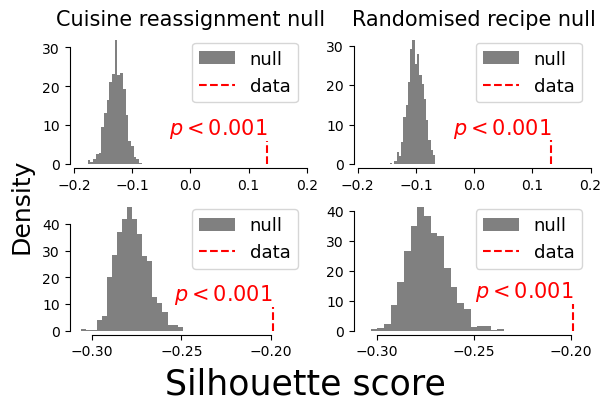

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(6,4 ), layout='constrained',)

output = np.histogram(RCshuff_is_c_sil_means, bins=20)
pbound = 1/len(seeds)

test_x =c_sil_score
ys = np.arange(7)
ax[0,0].hist(RCshuff_is_c_sil_means, color='grey', fill=True, density=True, bins=20, label='null')
ax[0,0].plot([test_x for y in ys], ys, 'r--',  label='data')
addtext = rf'$p < {pbound}$'
# addtext = f'$s={test_x:.2f}$\n$p < {pbound}$'

ax[0,0].text(test_x, ys[-1], addtext, horizontalalignment='right', verticalalignment='bottom', color='red', size=15)
ax[0,0].legend(prop={'size':13})
ax[0,0].set_xlim(-0.2, 0.2)
# ax[0,0].set_ylabel('Cuisine clustering', size=10, color='#144484')
# ax[0,0].text(-0.5, 0.5, 'Cuisine\nclustering', horizontalalignment='center', verticalalignment='center', fontsize=15, transform=ax[0,0].transAxes, color='#144484')

ax[0,0].set_title('Cuisine reassignment null', size=15)
sns.despine(offset=3, trim=True, ax=ax[0,0])


output = np.histogram(RIshuff_is_c_sil_means, bins=20)
test_x =c_sil_score
ys = np.arange(7)
ax[0,1].hist(RIshuff_is_c_sil_means, color='grey', fill=True, density=True, bins=20, label='null') # #5A7CA8
ax[0,1].plot([test_x for y in ys], ys, 'r--',  label='data')
addtext = rf'$p < {pbound}$'
# addtext = f'$s={test_x:.2f}$\n$p < {pbound}$'

ax[0,1].text(test_x, ys[-1], addtext, horizontalalignment='right', verticalalignment='bottom', color='red', size=15)
ax[0,1].legend(prop={'size':13})
ax[0,1].set_xlim(-0.2, 0.2)

ax[0,1].set_title('Randomised recipe null', size=15)
sns.despine(offset=3, trim=True, ax=ax[0,1])



output = np.histogram(RCshuff_cs_i_sil_means, bins=20)
test_x =i_sil_score
ys = np.arange(10) 
ax[1,0].hist(RCshuff_cs_i_sil_means, color='grey', fill=True, density=True, bins=20, label='null') # #F88E86
ax[1,0].plot([test_x for y in ys], ys, 'r--',  label='data')
addtext = rf'$p < {pbound}$'
# addtext = f'$s={test_x:.2f}$\n$p < {pbound}$'

ax[1,0].text(test_x, ys[-1], addtext, horizontalalignment='right', verticalalignment='bottom', color='red', size=15)
ax[1,0].legend(prop={'size':13})
ax[1,0].set_xlim(-0.31, -0.18)
ax[1,0].set_xticks([-0.3, -0.25, -0.2])

# ax[1,0].set_ylabel('Ingredient\nclustering', size=15, color='#F44336', rotation=0, labelpad=10, ha='right')
# ax[1,0].text(-0.5, 0.5, 'Ingredient\nclustering', horizontalalignment='center', verticalalignment='center', fontsize=15, transform=ax[1,0].transAxes, color='#F44336')
sns.despine(offset=3, trim=True, ax=ax[1,0])


output = np.histogram(RIshuff_cs_i_sil_means, bins=20)
test_x =i_sil_score
ys = np.arange(10)
ax[1,1].hist(RIshuff_cs_i_sil_means, color='grey', fill=True, density=True, bins=20, label='null')
ax[1,1].plot([test_x for y in ys], ys, 'r--',  label='data')
addtext = rf'$p < {pbound}$'
# addtext = f'$s={test_x:.2f}$\n$p < {pbound}$'

ax[1,1].text(test_x, ys[-1], addtext, horizontalalignment='right', verticalalignment='bottom', color='red', size=15,)
ax[1,1].legend(prop={'size':13})
ax[1,1].set_xlim(-0.31, -0.19)
ax[1,1].set_xticks([-0.3, -0.25, -0.2])

sns.despine(offset=3, trim=True, ax=ax[1,1])



fig.supylabel('Density', size=18)
fig.supxlabel('Silhouette score', size=25)
# save_things=False
if save_things:
    plt.savefig(f'{rn_save_dir}/f3d_recipe_silhouette_nulls.png', dpi=300, bbox_inches='tight')
    plt.savefig(f'{rn_save_dir}/f3d_recipe_silhouette_nulls.pdf', dpi=300, bbox_inches='tight')  
plt.show()